In [2]:
import xgboost as xgb
import scipy.sparse
import pickle
import numpy as np
import boto3
import awscli
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca
import scipy.sparse
import shap

In [3]:
features = []
featofvar = 'Type and Serum'

remote_folder = '10_04_18_COOH_PEG_serum' #Folder in AWS S3 containing files to be analyzed
bucket = 'rhodese.data'
vids = 10
types = ['COOH', 'COOH_serum', 'PEG', 'PEG_serum']

counter2 = 0
counter = 0
for typ in types:
    for num in range(1, vids+1):
            try:
                filename = 'features_{}_XY{}.csv'.format(typ, '%02d' % num)
                print(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
                print('{} size: {}'.format(filename, fstats.shape))
                fstats['Type and Serum'] = pd.Series(fstats.shape[0]*[typ], index=fstats.index)
                if 'serum' in typ:
                    fstats['Serum'] = pd.Series(fstats.shape[0]*['serum'], index=fstats.index)
                else:
                    fstats['Serum'] = pd.Series(fstats.shape[0]*['no serum'], index=fstats.index)
                if 'COOH' in typ:
                    fstats['Type'] = pd.Series(fstats.shape[0]*['COOH'], index=fstats.index)
                else:
                    fstats['Type'] = pd.Series(fstats.shape[0]*['PEG'], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('Skipped!: {}'.format(filename))
    counter2 = counter2 + 1

features_COOH_XY01.csv
features_COOH_XY01.csv size: (14913, 67)
features_COOH_XY02.csv
features_COOH_XY02.csv size: (14225, 67)
features_COOH_XY03.csv
features_COOH_XY03.csv size: (14767, 67)
features_COOH_XY04.csv
features_COOH_XY04.csv size: (14936, 67)
features_COOH_XY05.csv
features_COOH_XY05.csv size: (15344, 67)
features_COOH_XY06.csv
features_COOH_XY06.csv size: (63173, 67)
features_COOH_XY07.csv
features_COOH_XY07.csv size: (42620, 67)
features_COOH_XY08.csv
features_COOH_XY08.csv size: (43427, 67)
features_COOH_XY09.csv
features_COOH_XY09.csv size: (19220, 67)
features_COOH_XY10.csv
features_COOH_XY10.csv size: (27610, 67)
features_COOH_serum_XY01.csv
features_COOH_serum_XY01.csv size: (42821, 67)
features_COOH_serum_XY02.csv
features_COOH_serum_XY02.csv size: (42778, 67)
features_COOH_serum_XY03.csv
features_COOH_serum_XY03.csv size: (42996, 67)
features_COOH_serum_XY04.csv
features_COOH_serum_XY04.csv size: (43391, 67)
features_COOH_serum_XY05.csv
features_COOH_serum_XY05.cs

In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [5]:
def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [103]:
categories = fstats_tot.columns[1:-4].drop([
    'SN_Ratio', 'Quality', 'Mean_Intensity', 'Mean SN_Ratio', 
    'Std Mean_Intensity', 'Mean Mean_Intensity', 'X', 'Y', 
    'Mean X', 'Std X', 'Mean Y', 'Std Y', 
    'Mean Quality', 'Std Quality', 'Mean Mean_Intensity', 'Std Mean_Intensity', 
    'Std SN_Ratio', 'frames', 'Mean frames', 'Std frames',])

In [111]:
fstats_tot

,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,...,Mean SN_Ratio,Std SN_Ratio,Mean Deff1,Std Deff1,Mean Deff2,Std Deff2,Type and Serum,Serum,Type,Video Number
0,0.0,0.013357,1.298800e+00,4.410776,0.531573,0.395825,0.098360,1.753261,0.429634,0.052430,...,0.532133,0.264508,3.634851,2.802466,0.868814,1.334294,COOH,no serum,COOH,1.0
1,1.0,0.243577,7.230828e+01,2.878273,0.538559,0.391780,0.100360,1.182076,0.154031,0.020658,...,0.703587,0.366796,4.510720,2.304267,3.658641,2.998946,COOH,no serum,COOH,1.0
2,2.0,0.493665,7.733242e+00,2.552122,0.888710,0.171719,0.287481,1.952608,0.487864,0.021079,...,0.628796,0.318922,3.786713,2.295931,1.056301,1.718423,COOH,no serum,COOH,1.0
3,3.0,0.077020,4.131074e+01,2.740295,0.109774,0.708707,0.014638,1.021856,0.021388,0.027522,...,0.456769,0.122584,4.655983,2.372913,3.780097,3.289666,COOH,no serum,COOH,1.0
4,4.0,0.054428,2.991126e+01,2.757350,0.714662,0.289464,0.164660,1.268013,0.211365,0.062128,...,0.456769,0.122584,4.655983,2.372913,3.780097,3.289666,COOH,no serum,COOH,1.0
5,5.0,0.128045,2.640576e+01,1.828857,0.778746,0.249873,0.198570,1.653155,0.395096,0.054854,...,0.483208,0.112311,3.893504,2.546849,2.635471,0.988531,COOH,no serum,COOH,1.0
6,6.0,1.376396,7.418656e-01,1.615523,0.926927,0.137724,0.338559,1.925796,0.480734,0.008327,...,0.544731,0.230474,5.412049,4.948647,2.684104,2.273661,COOH,no serum,COOH,1.0
7,7.0,5.583545,1.755010e-10,12.568155,0.760262,0.261564,0.187906,2.345472,0.573647,0.010167,...,0.532133,0.264508,3.634851,2.802466,0.868814,1.334294,COOH,no serum,COOH,1.0
8,8.0,2.318731,3.000465e-02,3.340573,0.981027,0.069201,0.476317,2.768109,0.638743,0.005423,...,0.470360,0.088161,3.538892,2.290592,3.951339,3.707407,COOH,no serum,COOH,1.0
9,9.0,0.301815,7.237135e-01,3.429356,0.644280,0.330855,0.135133,1.586377,0.369633,0.114513,...,0.483208,0.112311,3.893504,2.546849,2.635471,0.988531,COOH,no serum,COOH,1.0


In [324]:
categories

Index(['alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2', 'asymmetry3',
       'AR', 'elongation', 'boundedness', 'fractal_dim', 'trappedness',
       'efficiency', 'straightness', 'MSD_ratio', 'frames', 'Deff1', 'Deff2'],
      dtype='object')

In [95]:
categories = fstats_tot.columns.drop([
       'SN_Ratio','Quality', 'Mean_Intensity', 'Mean SN_Ratio', 
       'Std Mean_Intensity', 'Mean Mean_Intensity', 'X', 'Y', 
       'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality', 
       'Mean Mean_Intensity', 'Std Mean_Intensity', 'Std SN_Ratio','Mean alpha', 
       'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis','Std kurtosis', 
       'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2',
       'Std asymmetry2', 'Mean asymmetry3', 'Std asymmetry3', 'Mean AR',
       'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness',
       'Std boundedness', 'Mean fractal_dim', 'Std fractal_dim',
       'Mean trappedness', 'Std trappedness', 'Mean efficiency',
       'Std efficiency', 'Mean straightness', 'Std straightness',
       'Mean MSD_ratio', 'Std MSD_ratio', 'Mean frames', 'Std frames',
       'Mean Deff1', 'Std Deff1', 'Mean Deff2', 'Std Deff2', 'Serum', 'Type', 
    'Video Number', 'binx', 'biny', 'bins', 'Track_ID', 'Type and Serum', 'frames'])

In [307]:
categories = fstats_tot.columns.drop([
    'SN_Ratio', 'Quality', 'Mean_Intensity', 'Mean SN_Ratio', 
    'Std Mean_Intensity', 'Mean Mean_Intensity', 'X', 'Y', 
    'Mean X', 'Std X', 'Mean Y', 'Std Y', 
    'Mean Quality', 'Std Quality', 'Mean Mean_Intensity', 'Std Mean_Intensity', 
    'Std SN_Ratio', 'frames', 'Mean frames', 'Std frames', 'Serum', 'Type', 
    'Video Number', 'binx', 'biny', 'bins', 'Track_ID', 'Type and Serum',])

In [10]:
def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)

    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [6]:
bins = list(range(0, 2048+1, 256))
fstats_tot['binx'] = pd.cut(fstats_tot.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['biny'] = pd.cut(fstats_tot.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['bins'] = 8*fstats_tot['binx'].astype(np.int8) + fstats_tot['biny'].astype(np.int8)
fstats_tot = fstats_tot[np.isfinite(fstats_tot['bins'])]
fstats_tot['bins'] = fstats_tot['bins'].astype(int)

cols = fstats_tot.columns.tolist()
cols = cols[-3:] + cols[:-3]
fstats_tot = fstats_tot[cols]

In [26]:
from sklearn.model_selection import train_test_split
X_train = fstats_tot[~fstats_tot.bins.isin(checkerboard(7))].reset_index()
X_test_val =  fstats_tot[fstats_tot.bins.isin(checkerboard(7))].reset_index()
y_train = le.fit_transform(X_train['Type and Serum'])
# y_test = le.fit_transform(X_test_val['Type and Serum'])
X_val, X_test = train_test_split(X_test_val, test_size=0.5, random_state=123)
y_test = le.fit_transform(X_test['Type and Serum'])
y_val = le.fit_transform(X_val['Type and Serum'])
dtrain = xgb.DMatrix(X_train[categories], label=y_train)
dtest = xgb.DMatrix(X_test[categories], label=y_test)
dval = xgb.DMatrix(X_val[categories], label=y_val)

In [27]:
np.unique(y_train)

array([0, 1])

In [11]:
dtrain.num_row()

938698

In [12]:
dtest.num_row()

261545

In [13]:
dval.num_row()

261545

In [14]:
print(dtest.num_row() +  dtrain.num_row() + dval.num_row())
print(100*dtest.num_row() /  dtrain.num_row())
print(100*dtrain.num_row() / fstats_tot.shape[0])

1461788
27.862528736611775
64.21574127027996


In [331]:
fstats_tot.shape

(487557, 74)

## If not doing checkerboard

In [112]:
from sklearn.model_selection import train_test_split
D_train, D_test_val = train_test_split(fstats_tot, test_size=0.2, random_state=123)
D_test, D_val = train_test_split(D_test_val, test_size=0.2, random_state=123)

X_train, y_train = D_train[categories],le.fit_transform(D_train.iloc[:,-4])
X_test, y_test = D_test[categories],le.fit_transform(D_test.iloc[:,-4])
X_val, y_val = D_val[categories],le.fit_transform(D_val.iloc[:,-4])

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)

In [333]:
df = bst.trees_to_dataframe()

In [334]:
param = {'max_depth':2, 'eta':0.3, 'verbosity':0, 'objective':'multi:softprob', 'num_class':4}

In [335]:
watchlist = [(dval, 'eval'), (dtrain, 'train')]
num_round = 10
bst = xgb.train(param, dtrain, num_round, watchlist)

[0]	eval-merror:0.213668	train-merror:0.212815
[1]	eval-merror:0.213668	train-merror:0.212815
[2]	eval-merror:0.21337	train-merror:0.212566
[3]	eval-merror:0.213645	train-merror:0.212787
[4]	eval-merror:0.21337	train-merror:0.212566
[5]	eval-merror:0.21337	train-merror:0.21257
[6]	eval-merror:0.213645	train-merror:0.212787
[7]	eval-merror:0.213324	train-merror:0.212522
[8]	eval-merror:0.213324	train-merror:0.212525
[9]	eval-merror:0.213197	train-merror:0.212404


In [1]:
label = dtest.get_label()
ypred1 = bst.predict(dtest, ntree_limit=1)
# by default, we predict using all the trees
ypred2 = bst.predict(dtest)
print('error of ypred1=%f' % (np.sum((ypred1 > 0.5) != label) / float(len(label))))
print('error of ypred2=%f' % (np.sum((ypred2 > 0.5) != label) / float(len(label))))

NameError: name 'dtest' is not defined

In [337]:
ypred2

array([[0.7842611 , 0.15593714, 0.02990089, 0.02990089],
       [0.7111845 , 0.22157727, 0.0336191 , 0.0336191 ],
       [0.8082073 , 0.13570195, 0.02804537, 0.02804537],
       ...,
       [0.717008  , 0.21710952, 0.03294122, 0.03294122],
       [0.74808407, 0.18695687, 0.03247952, 0.03247952],
       [0.7202364 , 0.21358448, 0.03308954, 0.03308954]], dtype=float32)

In [338]:
ypred2_binary = ypred2
prediction = []
for i in ypred2_binary:
    for j in range(len(i)):
        if i[j] == i.max(): prediction.append(j)
# [np.where(i == 1, i) for i in ypred2_binary]
    

In [350]:
X_test['Type and Serum'].values

array(['COOH_serum', 'COOH_serum', 'COOH_serum', ..., 'COOH_serum',
       'COOH_serum', 'PEG'], dtype=object)

In [352]:
prediction = le.inverse_transform(prediction)

ValueError: y contains previously unseen labels: ['COOH_serum' 'PEG']

In [341]:
prediction

array(['COOH_serum', 'COOH_serum', 'COOH_serum', ..., 'COOH_serum',
       'COOH_serum', 'COOH_serum'], dtype=object)

In [342]:
from sklearn.metrics import classification_report

In [349]:
len(X_test['Type and Serum'])

87004

In [346]:
len(prediction)

87004

In [348]:
print(classification_report(X_test['Type and Serum'], prediction, digits=4))

              precision    recall  f1-score   support

  COOH_serum     0.7862    0.9999    0.8803     68367
         PEG     0.9231    0.0026    0.0051     18637

   micro avg     0.7863    0.7863    0.7863     87004
   macro avg     0.8546    0.5013    0.4427     87004
weighted avg     0.8155    0.7863    0.6928     87004



In [359]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test[categories])

In [360]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test[categories])

TypeError: list indices must be integers or slices, not tuple

In [284]:
shap.summary_plot(shap_values, X_test[categories], plot_type="dot")

In [32]:
shap_values

[array([[ 0.        ,  0.        ,  0.        , ..., -0.10125249,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.17506643,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.06508382,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.00649954,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.16389123,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.06799544,
          0.        ,  0.        ]], dtype=float32),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.02478581,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.01008733,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.02478581,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.01008733,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.01008733,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.01008733,
         0.        ]], dtype=float32),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.02634012],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.03068789],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.04673495],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.04673495],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.03068789],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.03068789]], dtype=float32),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.01566629,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.18570545,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.01566629,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.03620334,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.03620334,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.03620334,
          0.        ,  0.        ]], dtype=float32)]

# For binary classification 
--------------------------------------------------------------------------

In [33]:
features = []
featofvar = 'Type and Serum'

remote_folder = '10_04_18_COOH_PEG_serum' #Folder in AWS S3 containing files to be analyzed
bucket = 'rhodese.data'
vids = 10
types = ['COOH', 'COOH_serum', 'PEG', 'PEG_serum']

counter2 = 0
counter = 0
for typ in types:
    for num in range(1, vids+1):
            try:
                filename = 'features_{}_XY{}.csv'.format(typ, '%02d' % num)
                print(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
                print('{} size: {}'.format(filename, fstats.shape))
                fstats['Type and Serum'] = pd.Series(fstats.shape[0]*[typ], index=fstats.index)
                if 'serum' in typ:
                    fstats['Serum'] = pd.Series(fstats.shape[0]*['serum'], index=fstats.index)
                else:
                    fstats['Serum'] = pd.Series(fstats.shape[0]*['no serum'], index=fstats.index)
                if 'COOH' in typ:
                    fstats['Type'] = pd.Series(fstats.shape[0]*['COOH'], index=fstats.index)
                else:
                    fstats['Type'] = pd.Series(fstats.shape[0]*['PEG'], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('Skipped!: {}'.format(filename))
    counter2 = counter2 + 1

features_COOH_XY01.csv
features_COOH_XY01.csv size: (14913, 67)
features_COOH_XY02.csv
features_COOH_XY02.csv size: (14225, 67)
features_COOH_XY03.csv
features_COOH_XY03.csv size: (14767, 67)
features_COOH_XY04.csv
features_COOH_XY04.csv size: (14936, 67)
features_COOH_XY05.csv
features_COOH_XY05.csv size: (15344, 67)
features_COOH_XY06.csv
features_COOH_XY06.csv size: (63173, 67)
features_COOH_XY07.csv
features_COOH_XY07.csv size: (42620, 67)
features_COOH_XY08.csv
features_COOH_XY08.csv size: (43427, 67)
features_COOH_XY09.csv
features_COOH_XY09.csv size: (19220, 67)
features_COOH_XY10.csv
features_COOH_XY10.csv size: (27610, 67)
features_COOH_serum_XY01.csv
features_COOH_serum_XY01.csv size: (42821, 67)
features_COOH_serum_XY02.csv
features_COOH_serum_XY02.csv size: (42778, 67)
features_COOH_serum_XY03.csv
features_COOH_serum_XY03.csv size: (42996, 67)
features_COOH_serum_XY04.csv
features_COOH_serum_XY04.csv size: (43391, 67)
features_COOH_serum_XY05.csv
features_COOH_serum_XY05.cs

In [34]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [35]:
categories = fstats_tot.columns[1:-4].drop([ 
    'SN_Ratio', 'Quality', 'Mean_Intensity', 'Mean SN_Ratio', 
    'Std Mean_Intensity', 'Mean Mean_Intensity', 'X', 'Y', 
    'Mean X', 'Std X', 'Mean Y', 'Std Y', 
    'Mean Quality', 'Std Quality', 'Mean Mean_Intensity', 'Std Mean_Intensity', 
    'Std SN_Ratio',])

In [36]:
fstats_tot = fstats_tot[fstats_tot['Type and Serum'] != 'COOH']
fstats_tot = fstats_tot[fstats_tot['Type and Serum'] != 'PEG_serum']

In [37]:
fstats_tot['Type and Serum'].unique()

array(['COOH_serum', 'PEG'], dtype=object)

In [38]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [39]:
fstats_tot

,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,...,Mean SN_Ratio,Std SN_Ratio,Mean Deff1,Std Deff1,Mean Deff2,Std Deff2,Type and Serum,Serum,Type,Video Number
270235,0.0,1.946523,0.153173,3.526872,0.879186,0.179384,0.277164,2.421783,0.587081,0.015902,...,0.624305,0.269352,4.469564,2.094588,3.460707,2.570202,COOH_serum,serum,COOH,1.0
270236,1.0,0.514425,12.660709,2.464399,0.899239,0.162928,0.299828,2.128232,0.530126,0.050995,...,0.624305,0.269352,4.469564,2.094588,3.460707,2.570202,COOH_serum,serum,COOH,1.0
270237,2.0,0.533579,19.360647,2.033628,0.390075,0.480731,0.063461,1.318343,0.241472,0.013404,...,0.519991,0.119672,4.179417,2.363912,2.723924,2.013603,COOH_serum,serum,COOH,1.0
270238,3.0,2.425292,0.001416,3.120621,0.462787,0.436205,0.080182,1.585190,0.369161,0.005646,...,0.580278,0.245230,4.527637,2.324992,3.125554,2.892308,COOH_serum,serum,COOH,1.0
270239,4.0,0.897309,8.159148,4.053894,0.926653,0.137992,0.338119,1.726612,0.420831,0.021756,...,0.621374,0.293617,4.084067,2.222167,3.672019,2.511455,COOH_serum,serum,COOH,1.0
270240,5.0,1.245260,1.848975,2.652762,0.993419,0.040630,0.553318,3.445878,0.709798,0.011504,...,0.620212,0.259139,4.093266,2.271960,3.080923,3.146508,COOH_serum,serum,COOH,1.0
270241,6.0,1.826195,0.313171,1.977668,0.679949,0.310059,0.149289,1.784078,0.439486,0.032980,...,0.816378,0.394810,3.872533,2.141536,3.031879,2.557363,COOH_serum,serum,COOH,1.0
270242,7.0,0.691531,7.875600,1.993296,0.891465,0.169453,0.290610,1.512567,0.338872,0.053184,...,0.514100,0.119646,4.630906,2.352434,3.726892,3.116268,COOH_serum,serum,COOH,1.0
270243,8.0,0.761004,16.215459,1.538403,0.945650,0.118193,0.372434,2.326438,0.570158,0.008049,...,0.816378,0.394810,3.872533,2.141536,3.031879,2.557363,COOH_serum,serum,COOH,1.0
270244,9.0,0.917651,4.297759,1.753289,0.600999,0.355819,0.119765,1.906584,0.475502,0.015097,...,0.514100,0.119646,4.630906,2.352434,3.726892,3.116268,COOH_serum,serum,COOH,1.0


In [42]:
categories = fstats_tot.columns.drop([
    'SN_Ratio', 'Quality', 'Mean_Intensity', 'Mean SN_Ratio', 
    'Std Mean_Intensity', 'Mean Mean_Intensity', 'X', 'Y', 
    'Mean X', 'Std X', 'Mean Y', 'Std Y', 
    'Mean Quality', 'Std Quality', 'Mean Mean_Intensity', 'Std Mean_Intensity', 
    'Std SN_Ratio', 'frames', 'Mean frames', 'Std frames', 'Serum', 'Type', 
    'Video Number', 'binx', 'biny', 'bins', 'Track_ID', 'Type and Serum',])

In [27]:
categories

Index(['alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2', 'asymmetry3',
       'AR', 'elongation', 'boundedness', 'fractal_dim', 'trappedness',
       'efficiency', 'straightness', 'MSD_ratio', 'Deff1', 'Deff2',
       'Mean alpha', 'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis',
       'Std kurtosis', 'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2',
       'Std asymmetry2', 'Mean asymmetry3', 'Std asymmetry3', 'Mean AR',
       'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness',
       'Std boundedness', 'Mean fractal_dim', 'Std fractal_dim',
       'Mean trappedness', 'Std trappedness', 'Mean efficiency',
       'Std efficiency', 'Mean straightness', 'Std straightness',
       'Mean MSD_ratio', 'Std MSD_ratio', 'Mean Deff1', 'Std Deff1',
       'Mean Deff2', 'Std Deff2'],
      dtype='object')

#### If using checkerboard

In [41]:
bins = list(range(0, 2048+1, 256))
fstats_tot['binx'] = pd.cut(fstats_tot.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['biny'] = pd.cut(fstats_tot.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['bins'] = 8*fstats_tot['binx'].astype(np.int8) + fstats_tot['biny'].astype(np.int8)
fstats_tot = fstats_tot[np.isfinite(fstats_tot['bins'])]
fstats_tot['bins'] = fstats_tot['bins'].astype(int)

cols = fstats_tot.columns.tolist()
cols = cols[-3:] + cols[:-3]
fstats_tot = fstats_tot[cols]

In [43]:
from sklearn.model_selection import train_test_split
X_train = fstats_tot[~fstats_tot.bins.isin(checkerboard(7))].reset_index()
X_test_val =  fstats_tot[fstats_tot.bins.isin(checkerboard(7))].reset_index()
y_train = le.fit_transform(X_train['Type and Serum'])
# y_test = le.fit_transform(X_test_val['Type and Serum'])
X_val, X_test = train_test_split(X_test_val, test_size=0.5, random_state=123)
y_test = le.fit_transform(X_test['Type and Serum'])
y_val = le.fit_transform(X_val['Type and Serum'])
dtrain = xgb.DMatrix(X_train[categories], label=y_train)
dtest = xgb.DMatrix(X_test[categories], label=y_test)
dval = xgb.DMatrix(X_val[categories], label=y_val)

#### If not using checkerboard

In [30]:
from sklearn.model_selection import train_test_split
D_train, D_test_val = train_test_split(fstats_tot, test_size=0.2, random_state=123)
D_test, D_val = train_test_split(D_test_val, test_size=0.2, random_state=123)

X_train, y_train = D_train[categories],le.fit_transform(D_train.iloc[:,-4])
X_test, y_test = D_test[categories],le.fit_transform(D_test.iloc[:,-4])
X_val, y_val = D_val[categories],le.fit_transform(D_val.iloc[:,-4])

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)

In [44]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [45]:
np.unique(y_train)

array([0, 1])

In [46]:
dtrain.num_row()

313549

In [47]:
dtest.num_row()

87004

In [48]:
dval.num_row()

87004

In [49]:
param = {'max_depth':4, 'eta':.4, 'verbosity':0, 'objective':'binary:logistic'}

In [50]:
watchlist = [(dval, 'eval'), (dtrain, 'train')]
num_round = 15
bst = xgb.train(param, dtrain, num_round, watchlist)

[0]	eval-error:0.084559	train-error:0.066376
[1]	eval-error:0.078766	train-error:0.055165
[2]	eval-error:0.076042	train-error:0.047619
[3]	eval-error:0.066962	train-error:0.042105
[4]	eval-error:0.067813	train-error:0.03705
[5]	eval-error:0.063296	train-error:0.036686
[6]	eval-error:0.057124	train-error:0.027772
[7]	eval-error:0.056882	train-error:0.028206
[8]	eval-error:0.05563	train-error:0.025856
[9]	eval-error:0.052699	train-error:0.022628
[10]	eval-error:0.050101	train-error:0.018692
[11]	eval-error:0.052113	train-error:0.017363
[12]	eval-error:0.050239	train-error:0.014932
[13]	eval-error:0.048354	train-error:0.012374
[14]	eval-error:0.046389	train-error:0.010576


In [51]:
label = dtest.get_label()
ypred1 = bst.predict(dtest, ntree_limit=1)
# by default, we predict using all the trees
ypred2 = bst.predict(dtest)
print('error of ypred1=%f' % (np.sum((ypred1 > 0.5) != label) / float(len(label))))
print('error of ypred2=%f' % (np.sum((ypred2 > 0.5) != label) / float(len(label))))

error of ypred1=0.082157
error of ypred2=0.045182


In [52]:
ypred2_binary = ypred2
prediction = []
for i in ypred2_binary:
    prediction.append((i>0.5)*1)
# [np.where(i == 1, i) for i in ypred2_binary]
    

In [53]:
ypred2

array([0.01282253, 0.02722001, 0.35991406, ..., 0.18964541, 0.01259943,
       0.9450126 ], dtype=float32)

In [54]:
X_test['Type and Serum'].values

array(['COOH_serum', 'COOH_serum', 'COOH_serum', ..., 'COOH_serum',
       'COOH_serum', 'PEG'], dtype=object)

In [55]:
prediction = le.inverse_transform(prediction)

In [56]:
prediction

array(['COOH_serum', 'COOH_serum', 'COOH_serum', ..., 'COOH_serum',
       'COOH_serum', 'PEG'], dtype=object)

In [57]:
print('0 == {}'.format(le.inverse_transform([0])))
print('1 == {}'.format(le.inverse_transform([1])))

0 == ['COOH_serum']
1 == ['PEG']


In [58]:
from sklearn.metrics import classification_report

In [59]:
print(classification_report(X_test['Type and Serum'], prediction, digits=4))

              precision    recall  f1-score   support

  COOH_serum     0.9610    0.9824    0.9716     68367
         PEG     0.9296    0.8537    0.8900     18637

   micro avg     0.9548    0.9548    0.9548     87004
   macro avg     0.9453    0.9180    0.9308     87004
weighted avg     0.9543    0.9548    0.9541     87004



In [60]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test[categories])

In [52]:
X_test[categories]

,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,fractal_dim,...,Mean efficiency,Std efficiency,Mean straightness,Std straightness,Mean MSD_ratio,Std MSD_ratio,Mean Deff1,Std Deff1,Mean Deff2,Std Deff2
50635,0.972429,2.227472e+00,2.333337,0.540432,0.390697,0.100901,1.720788,0.418871,0.027603,1.888780,...,0.951578,0.830199,0.153887,0.096856,0.127373,0.364637,4.473593,2.276215,3.718616,3.298827
136637,2.049752,2.229297e-01,2.016002,0.843140,0.206470,0.243734,1.967475,0.491734,0.037564,1.592863,...,0.910583,1.024020,0.144094,0.105004,0.170970,0.482183,3.856188,1.981208,4.488944,3.594921
10080,0.464631,1.036494e+01,2.793045,0.643065,0.331559,0.134677,1.859343,0.462175,0.017171,1.784457,...,0.930982,0.969607,0.154323,0.102997,0.184229,0.555069,4.032759,2.087785,3.836472,2.733690
81710,1.226375,2.493743e+00,2.523764,0.970901,0.085922,0.437381,3.071630,0.674440,0.007140,1.490423,...,0.818996,0.890046,0.143821,0.095958,0.196560,0.683995,3.834663,2.078839,3.009421,2.607325
149242,1.534286,1.542877e+00,1.936701,0.491732,0.419066,0.087515,1.420177,0.295863,0.030407,1.428453,...,1.242083,1.146854,0.191324,0.102207,0.096403,0.354738,4.355512,2.634492,2.484333,1.001410
67412,1.074171,1.682796e+00,3.441176,0.757679,0.263178,0.186479,1.308944,0.236025,0.057290,1.796153,...,0.897186,1.047238,0.151018,0.116454,0.194677,0.530422,4.354459,2.670634,3.461806,3.080805
169582,0.567655,6.218401e+00,2.656935,0.530565,0.396409,0.098074,1.472467,0.320868,0.102238,2.160649,...,0.768671,0.586987,0.150321,0.086924,0.191908,0.735610,3.896374,2.065309,2.278976,1.832396
77693,0.417388,2.319220e+01,1.574662,0.978062,0.074468,0.463614,2.739857,0.635017,0.031230,1.513944,...,0.920144,0.965615,0.151841,0.104572,0.205242,0.702203,4.297421,2.047585,3.871926,2.905740
50551,1.934227,2.913464e-01,1.888503,0.965014,0.094356,0.419200,3.024794,0.669399,0.029411,1.433508,...,1.004072,1.023069,0.158327,0.103579,0.105926,0.385645,3.998830,1.985176,3.952445,4.397252
123273,0.469117,5.609040e+00,2.319727,0.010519,0.902197,0.001323,1.252039,0.201303,0.093903,1.713637,...,0.818106,0.949843,0.148528,0.110069,0.133355,0.400024,4.423866,2.891545,2.753111,1.638531


In [54]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[87000,:], X_test[categories].iloc[87000,:])

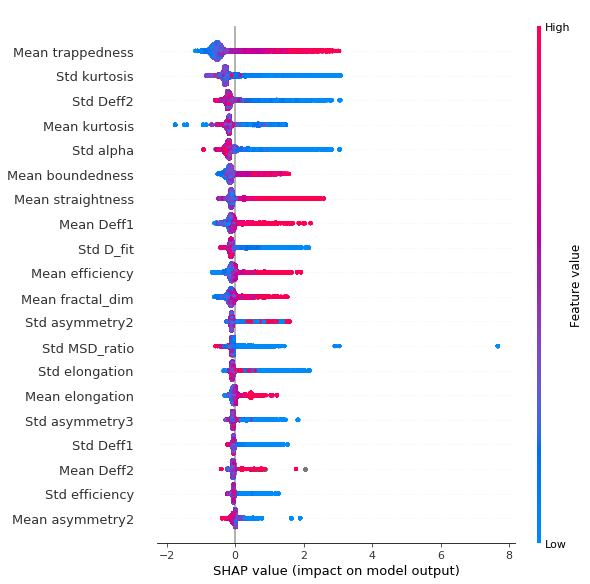

In [62]:
shap.summary_plot(shap_values, X_test[categories])

In [39]:
shap.visualize(shap_values[2,:], X.iloc[2,:], link=shap.LogitLink())

AttributeError: module 'shap' has no attribute 'visualize'

In [63]:
X_test

,index,binx,biny,bins,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,...,Mean SN_Ratio,Std SN_Ratio,Mean Deff1,Std Deff1,Mean Deff2,Std Deff2,Type and Serum,Serum,Type,Video Number
50635,411878,1,4,12,13048.0,0.972429,2.227472e+00,2.333337,0.540432,0.390697,...,0.657655,0.289901,4.473593,2.276215,3.718616,3.298827,COOH_serum,serum,COOH,4.0
136637,653203,6,0,48,41912.0,2.049752,2.229297e-01,2.016002,0.843140,0.206470,...,0.571607,0.120099,3.856188,1.981208,4.488944,3.594921,COOH_serum,serum,COOH,10.0
10080,296655,2,2,18,26420.0,0.464631,1.036494e+01,2.793045,0.643065,0.331559,...,0.625156,0.255291,4.032759,2.087785,3.836472,2.733690,COOH_serum,serum,COOH,1.0
81710,498365,0,4,4,12560.0,1.226375,2.493743e+00,2.523764,0.970901,0.085922,...,0.668631,0.324886,3.834663,2.078839,3.009421,2.607325,COOH_serum,serum,COOH,6.0
149242,689043,6,0,48,7725.0,1.534286,1.542877e+00,1.936701,0.491732,0.419066,...,0.589107,0.077563,4.355512,2.634492,2.484333,1.001410,PEG,no serum,PEG,5.0
67412,457772,2,4,20,15551.0,1.074171,1.682796e+00,3.441176,0.757679,0.263178,...,0.667911,0.286228,4.354459,2.670634,3.461806,3.080805,COOH_serum,serum,COOH,5.0
169582,745354,6,0,48,15033.0,0.567655,6.218401e+00,2.656935,0.530565,0.396409,...,0.712188,0.377026,3.896374,2.065309,2.278976,1.832396,PEG,no serum,PEG,9.0
77693,487427,1,6,14,1622.0,0.417388,2.319220e+01,1.574662,0.978062,0.074468,...,0.586860,0.230822,4.297421,2.047585,3.871926,2.905740,COOH_serum,serum,COOH,6.0
50551,411713,1,4,12,12883.0,1.934227,2.913464e-01,1.888503,0.965014,0.094356,...,0.549807,0.132821,3.998830,1.985176,3.952445,4.397252,COOH_serum,serum,COOH,4.0
123273,614916,3,6,30,3625.0,0.469117,5.609040e+00,2.319727,0.010519,0.902197,...,0.623070,0.290751,4.423866,2.891545,2.753111,1.638531,COOH_serum,serum,COOH,10.0


In [64]:
X_test['prediction'] = prediction

/root/anaconda3/envs/david/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [69]:
import matplotlib.pyplot as pl

In [ ]:
fstats1 = pca.feature_plot_3D(pca_train.final, label=featofvar, lvals=types, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], legendfontsize=24, labelfontsize=24, dpi=1600,
                              ticksize=20,
                              filename='./pics/Fig4/corona_3feats.png')

In [66]:
import diff_classifier.pca as pca
import sklearn.preprocessing as pp

In [ ]:
pca.preprocessing.StandardScaler()

In [100]:
COOH_serum_norm = pp.normalize(df_COOH_serum_pred[categories].replace([np.inf, -np.inf], np.nan).fillna(0), axis= 0)
PEG_norm = pp.normalize(df_PEG_pred[categories].replace([np.inf, -np.inf], np.nan).fillna(0), axis= 0)

In [312]:
COOH_serum_norm.shape

(69890, 48)

In [101]:
XX_COOH_serum = pp.normalize(COOH_serum_norm['Mean trappedness'].values.reshape(-1, 1), axis=0)
YY_COOH_serum = pp.normalize(COOH_serum_norm['Std kurtosis'].values.reshape(-1, 1), axis=0)
ZZ_COOH_serum = pp.normalize(COOH_serum_norm['Std Deff2'].values.reshape(-1, 1), axis=0)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [102]:
XX_PEG = pp.normalize(df_PEG_norm['Mean trappedness'].values.reshape(-1, 1), axis=0)
YY_PEG = pp.normalize(df_PEG_norm['Std kurtosis'].values.reshape(-1, 1), axis=0)
ZZ_PEG = pp.normalize(df_PEG_norm['Std Deff2'].replace([np.inf, -np.inf], np.nan).fillna(0).values.reshape(-1, 1), axis=0)

NameError: name 'df_PEG_norm' is not defined

<IPython.core.display.Javascript object>


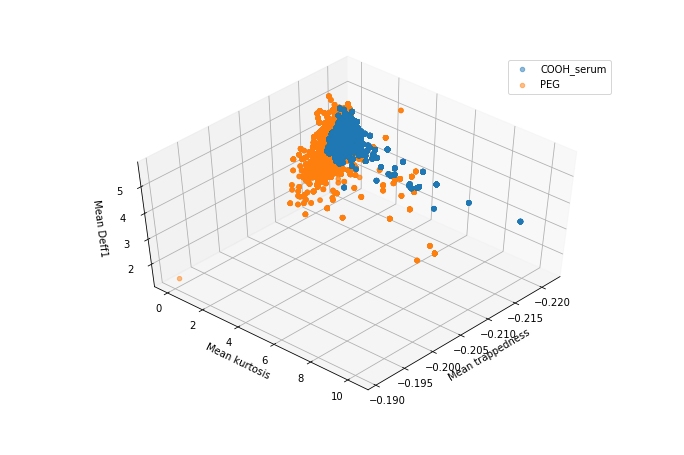

In [99]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
df_COOH_serum_pred = X_test[X_test['prediction'] == 'COOH_serum']
df_PEG_pred = X_test[X_test['prediction'] == 'PEG']
ax.scatter(df_COOH_serum_pred['Mean trappedness'], df_COOH_serum_pred['Std kurtosis'], df_COOH_serum_pred['Mean Deff1'], marker = 'o', alpha = 0.5)
ax.scatter(df_PEG_pred['Mean trappedness'], df_PEG_pred['Std kurtosis'], df_PEG_pred['Mean Deff1'], marker = 'o', alpha = 0.5)
ax.set_xlabel('Mean trappedness')
ax.set_ylabel('Mean kurtosis')
ax.set_zlabel('Mean Deff1')
leg = pl.legend(['COOH_serum', 'PEG'])

In [79]:
leg.set_alpha(1)
pl.show()

<IPython.core.display.Javascript object>


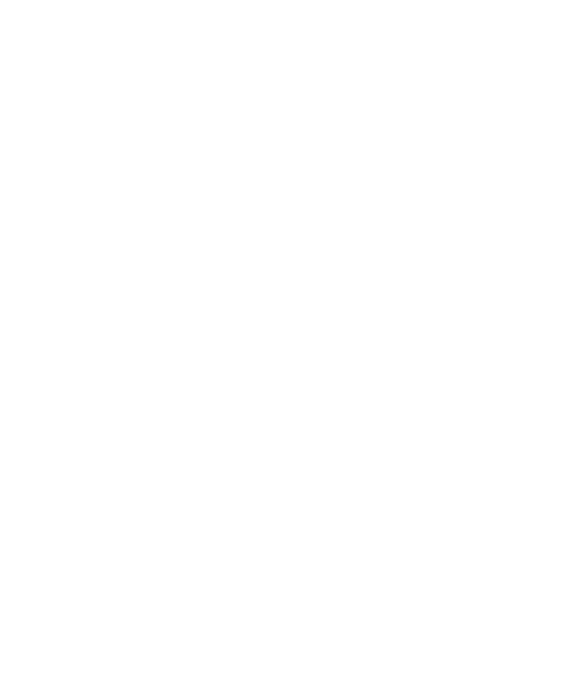

Text(0.5, 0, 'Std Deff2')

In [313]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
df_COOH_serum_pred = X_test[X_test['prediction'] == 'COOH_serum']
df_PEG_pred = X_test[X_test['prediction'] == 'PEG']
ax.scatter(df_COOH_serum_pred['Mean kurtosis'], df_COOH_serum_pred['Std kurtosis'], df_COOH_serum_pred['Std Deff2'], marker = 'o', alpha = 0.05)
ax.scatter(df_PEG_pred['Mean kurtosis'], df_PEG_pred['Std kurtosis'], df_PEG_pred['Std Deff2'], marker = 'o', alpha = 0.05)
ax.set_xlabel('Mean kurtosis')
ax.set_ylabel('Std kurtosis')
ax.set_zlabel('Std Deff2')
# ax.view_init(30, angle)
# pl.draw()
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     pl.draw()
#     pl.pause(.001)

In [251]:
r = pl.gcf().canvas.get_renderer()

ax.view_init(30, 0)
ax.draw(r)
pl.show()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

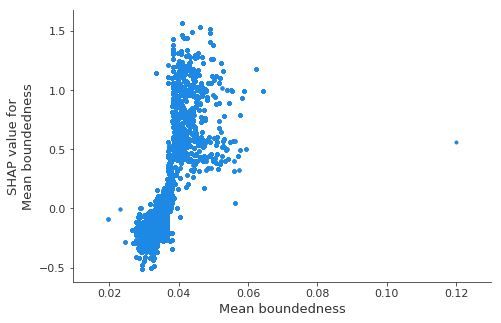

In [87]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
%matplotlib inline
shap.dependence_plot("Mean boundedness", shap_values, X_test[categories], interaction_index = None)

In [477]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.image_plot(shap_values, X_test[categories])

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fc9ce99e840> (for post_execute):


ValueError: Image size of 432x15660900 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 432x15660900 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x1.56609e+07 with 1420 Axes>

In [265]:
shap_inter_val = explainer.shap_interaction_values(X_test[categories])

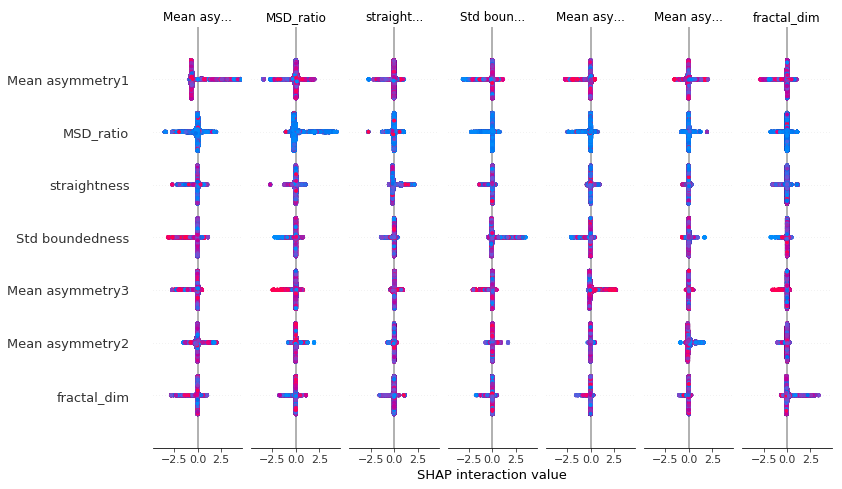

In [266]:
shap.summary_plot(shap_inter_val, X_test)

In [60]:
import matplotlib.pyplot as pl

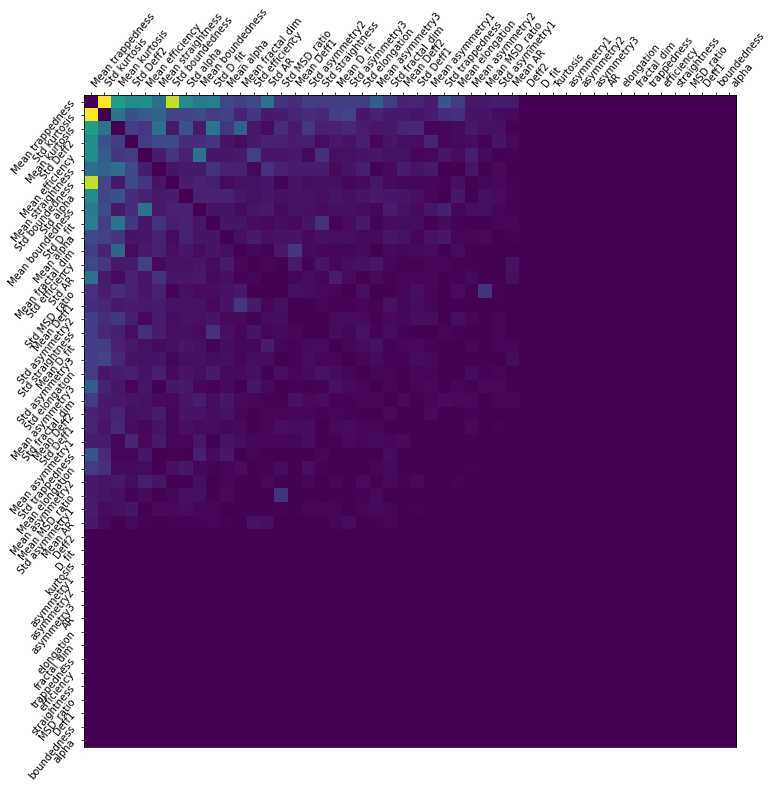

In [262]:
tmp = np.abs(shap_inter_val).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), X_test[categories].columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X_test[categories].columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()

In [71]:
X_test['prediction'] = prediction

/root/anaconda3/envs/david/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [58]:
bin_prediction = prediction

In [81]:
import seaborn as sns

Text(0.5, 0, '')

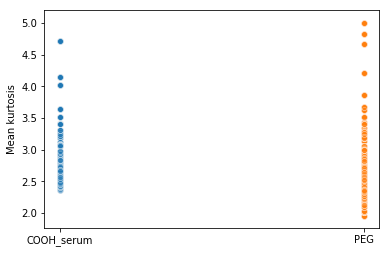

In [96]:
fig = pl.figure()
ax = fig.add_subplot(111)

df_COOH_serum_pred = X_test[X_test['prediction'] == 'COOH_serum']
df_PEG_pred = X_test[X_test['prediction'] == 'PEG']

sns.scatterplot(df_COOH_serum_pred['prediction'], df_COOH_serum_pred['Mean kurtosis'].values, alpha = 0.5)
sns.scatterplot(df_PEG_pred['prediction'], df_PEG_pred['Mean kurtosis'].values, alpha = 0.5)
ax.set_ylabel('Mean kurtosis')
ax.set_xlabel('')

Text(0, 0.5, 'Mean kurtosis')

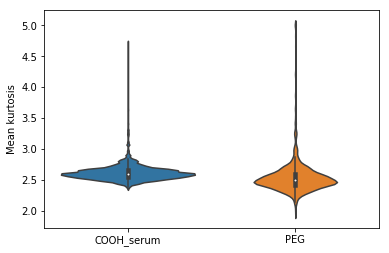

In [107]:
fig = pl.figure()
ax = fig.add_subplot(111)
ax = sns.violinplot(x=bin_prediction, y=X_test['Mean kurtosis'].values)
ax.set_ylabel('Mean kurtosis')

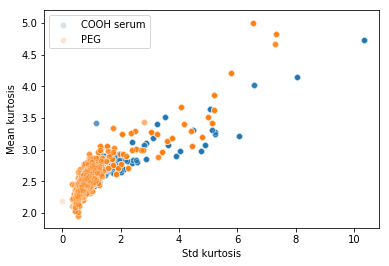

In [104]:

fig = pl.figure()

ax = fig.add_subplot(111)


df_COOH_serum_pred = X_test[X_test['prediction'] == 'COOH_serum']
df_PEG_pred = X_test[X_test['prediction'] == 'PEG']

sns.scatterplot(df_COOH_serum_pred['Std kurtosis'], df_COOH_serum_pred['Mean kurtosis'], marker = 'o', alpha = 0.2)
sns.scatterplot(df_PEG_pred['Std kurtosis'], df_PEG_pred['Mean kurtosis'], marker = 'o', alpha = 0.2)
ax.set_xlabel('Std kurtosis')
ax.set_ylabel('Mean kurtosis')

ax.legend(['COOH serum', 'PEG'])

In [1]:
shap.summary_plot(shap_values, X_test[categories], plot_type="bar")

NameError: name 'shap' is not defined

In [317]:
shap_values

array([[ 0.        ,  0.        ,  0.        , ..., -0.02159473,
        -0.04074033, -0.2621654 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.02952961,
         0.20199072, -0.27384752],
       [ 0.        ,  0.        ,  0.        , ..., -0.04394015,
        -0.07739055, -0.17656171],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.06433599,
        -0.05788338, -0.27876228],
       [ 0.        ,  0.        ,  0.        , ..., -0.00306593,
        -0.06851134, -0.18168877],
       [ 0.        ,  0.        ,  0.        , ..., -0.20658043,
        -0.055368  ,  0.12980068]], dtype=float32)

In [140]:
bin_prediction

array([0, 0, 0, ..., 0, 0, 1])

In [141]:
prediction

array(['COOH_serum', 'COOH_serum', 'COOH_serum', ..., 'COOH_serum',
       'COOH_serum', 'PEG'], dtype=object)

In [142]:
X_train['Std kurtosis']

433445    0.793726
493486    0.813375
708722    0.794962
541603    0.860625
669173    1.122714
656336    0.897268
295669    1.107006
619299    1.198412
493802    0.934912
427978    2.882448
590592    1.775158
585731    0.918910
449467    0.907112
616892    1.010479
654729    0.824442
501042    0.738375
423520    1.356787
737543    1.354254
397546    0.980974
283191    0.908284
722215    0.577925
338187    1.456867
665773    0.596191
584571    1.199232
612577    1.574184
583326    0.967228
714017    0.782748
591232    1.213319
635734    0.764782
513040    0.858644
            ...   
605900    0.907056
615391    1.399658
400491    1.311114
678395    0.731321
497983    0.997473
732312    1.730730
305897    0.951812
681198    0.816881
503092    0.746470
466954    1.490913
435017    1.065201
341435    0.754455
389092    1.015605
520138    1.166937
686617    1.210147
718860    0.962286
335867    1.070645
423548    1.073546
490609    2.361401
316438    0.915112
399365    1.311114
736750    0.

In [157]:
X_final = X_test
X_final['final_values'] = prediction

/root/anaconda3/envs/david/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [476]:
# shap.dependence_plot(('Mean trappedness', 'final_values'), shap_inter_val, X_final)


In [475]:
from sklearn.linear_model import LinearRegression

In [502]:
X_train

,index,Std Y,Mean Quality,Std Quality,Mean Mean_Intensity,Std Mean_Intensity,Mean SN_Ratio,Std SN_Ratio,Mean Deff1,Std Deff1,...,Std efficiency,Mean straightness,Std straightness,Mean MSD_ratio,Std MSD_ratio,Mean frames,Std frames,Mean X,Std X,Mean Y
0,270235,36.590067,12.151735,3.630297,NaN,NaN,0.624305,0.269352,4.469564,2.094588,...,0.925670,0.156486,0.094157,0.096165,0.317722,68.068182,46.893810,191.622258,42.407889,1596.063201
1,270236,36.590067,12.151735,3.630297,NaN,NaN,0.624305,0.269352,4.469564,2.094588,...,0.925670,0.156486,0.094157,0.096165,0.317722,68.068182,46.893810,191.622258,42.407889,1596.063201
2,270237,36.523372,12.840402,3.388265,NaN,NaN,0.519991,0.119672,4.179417,2.363912,...,0.906266,0.139252,0.094966,0.170522,0.501429,72.352041,55.664846,316.391825,36.918128,1858.906334
3,270238,37.871233,11.736565,3.322135,NaN,NaN,0.580278,0.245230,4.527637,2.324992,...,0.908109,0.153491,0.102309,0.229527,1.824266,66.378531,55.658342,451.479424,35.431163,1858.040961
4,270240,36.825219,12.740220,3.094435,NaN,NaN,0.620212,0.259139,4.093266,2.271960,...,0.955640,0.154363,0.110672,0.100002,0.272839,71.777143,57.426341,67.930892,36.237542,1724.953858
5,270242,36.046494,12.412750,3.866711,NaN,NaN,0.514100,0.119646,4.630906,2.352434,...,1.041027,0.154086,0.108839,0.154310,0.489936,69.747126,50.580701,189.641074,34.404515,1732.845449
6,270244,36.046494,12.412750,3.866711,NaN,NaN,0.514100,0.119646,4.630906,2.352434,...,1.041027,0.154086,0.108839,0.154310,0.489936,69.747126,50.580701,189.641074,34.404515,1732.845449
7,270245,33.629831,12.051327,2.845796,NaN,NaN,0.613202,0.253180,4.340241,2.052473,...,0.858579,0.146611,0.090653,0.387911,2.270566,70.169154,55.221861,447.758865,35.834801,1980.265655
8,270246,36.046494,12.412750,3.866711,NaN,NaN,0.514100,0.119646,4.630906,2.352434,...,1.041027,0.154086,0.108839,0.154310,0.489936,69.747126,50.580701,189.641074,34.404515,1732.845449
9,270247,37.228898,12.570870,3.875847,NaN,NaN,0.590280,0.282096,4.406438,2.411404,...,1.124552,0.158700,0.114787,0.142793,0.550452,69.441489,54.127723,323.984029,33.424345,1978.534476


In [499]:
linear_model = LinearRegression()
linear_model.fit(df2, X_train['Type and Serum'])

print('linear model coeff: \n' + str(linear_model.coef_))

# TODO: Write your code here to train the two models

ValueError: could not convert string to float: 'COOH_serum'

In [486]:
df = X_train[categories].replace([np.inf, -np.inf], np.nan)
df2 = df.fillna(0)

In [498]:
from sklearn.metrics import mean_squared_error as mse
linear_pred = linear_model.predict(X_test[categories].replace([np.inf, -np.inf], np.nan).fillna(0))
mse_linear = mse(y_test, linear_pred)

print('error: ~{:,}'.format(np.round(np.sqrt(mse_linear))))

error: ~0.0


In [504]:
# ans = [i > 0.5 for i in linear_pred]
# ans

In [496]:
linear_pred

array([0.19600615, 0.24206475, 0.16575304, ..., 0.22691162, 0.20257655,
       0.29334619])

In [ ]:
y_test

In [503]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [528]:
param_grid = {'n_estimators': [15, 25]}
model = GridSearchCV(RandomForestRegressor(), param_grid, cv = 5)
model = model.fit(X_train[categories].replace([np.inf, -np.inf], np.nan).fillna(0),y_train)


KeyboardInterrupt: 

In [513]:
print("Best parameters found by grid search:")
print(model.best_params_)
print("Best CV score:")
print(model.best_score_)
predsrf = model.predict(X_test[categories].replace([np.inf, -np.inf], np.nan).fillna(0))

Best parameters found by grid search:
{'n_estimators': 15}
Best CV score:
-0.5886153204260449


In [518]:
rf_pred = [1*(i > 0.5) for i in predsrf]

In [ ]:
y_test

In [520]:
print(classification_report(X_test['Type and Serum'], le.inverse_transform(rf_pred), digits=4))

              precision    recall  f1-score   support

  COOH_serum     0.7896    0.9671    0.8694     68367
         PEG     0.3129    0.0549    0.0934     18637

   micro avg     0.7717    0.7717    0.7717     87004
   macro avg     0.5513    0.5110    0.4814     87004
weighted avg     0.6875    0.7717    0.7032     87004



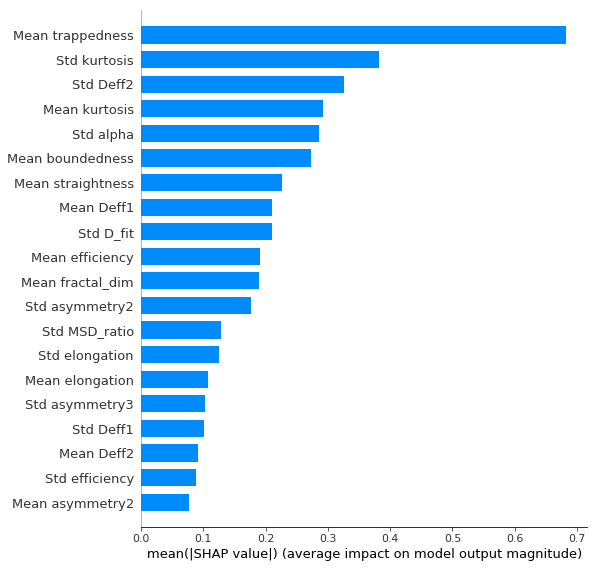

In [55]:
shap.summary_plot(shap_values, X_test[categories], plot_type="bar")